# 1. Necessary Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Set2')

In [2]:
import datetime as dt
import dateutil
import string

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import importlib

In [4]:
imp = pd.read_excel(r'C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Skytrax DF Cleaned.xlsx')
imp.head()

,Unnamed: 0,airline,review_score,traveller_type,cabin,seat_comfort,cabin_service,food_bev,entertainment,ground_service,...,review_date_month,review_date_year,date_flown_day,date_flown_month,date_flown_year,review_date_date_flown_distance_days,review_characters,pos_neu_neg_review_score,has_layover,recommended
0,1,Turkish Airlines,7,Business,Economy Class,4,5,4,4,2,...,5,2019,1,5,2019,7,1094,pos,True,True
1,3,Turkish Airlines,2,Family Leisure,Economy Class,4,1,1,1,1,...,5,2019,1,5,2019,6,425,neg,False,False
2,5,Turkish Airlines,3,Business,Economy Class,1,4,1,3,1,...,5,2019,1,5,2019,6,1597,neg,True,False
3,7,Turkish Airlines,10,Solo Leisure,Economy Class,4,5,5,5,5,...,5,2019,8,4,2019,28,875,pos,False,True
4,9,Turkish Airlines,1,Solo Leisure,Economy Class,1,1,1,1,1,...,5,2019,1,5,2019,5,366,neg,True,False


# 2 Prepare Data for Text Classification

## 2.1 Create new DF with only 'airline', 'cabin' and 'review'

In [5]:
df = imp[['airline', 'cabin', 'review_text']].copy()
df.head()

,airline,cabin,review_text
0,Turkish Airlines,Economy Class,First time Iâ€™d flown TK. I found them very ...
1,Turkish Airlines,Economy Class,"We make our check in in the airport, they Tak..."
2,Turkish Airlines,Economy Class,I flew with this company several times in the...
3,Turkish Airlines,Economy Class,Turkish Airlines has consistently maintained ...
4,Turkish Airlines,Economy Class,Never book Turkish airlines if you are travel...


In [6]:
df.iloc[0,2]

' First time Iâ€™d flown TK. I found them very good in the air, cabin crew, planes, food, all very nice. Not so great on the ground, ground staff, call centre, computer systems. My flight from LHR was delayed so I missed the connection in Istanbul. Most ground staff donâ€™t speak English, and I was given contradictory instructions from those that could speak a little English. I eventually got on a flight to Izmir three hours later, but it wasnâ€™t an easy process, made worse by the vast distances one has to walk between gates in the cavernous new airport. Also, Iâ€™d phoned a TK call centre (based in Ukraine) to pay an extra Â£40 or so each way for extra leg room seats. However, as the departure times kept changing, my seats kept changing, and for the return leg to London from Istanbul I was not given an extra leg room seat. Luckily there was a spare exit row seat and the cabin crew sorted me out. Overall, I think their cabin crew and planes are very good, ground staff and call centre 

In [7]:
df.iloc[1694]

airline        Qatar Airways
cabin          Economy Class
review_text              NaN
Name: 1694, dtype: object

### 2.1.1 Get rid of empty values/NAs in the df

In [8]:
len(df)

22822

In [9]:
df.dropna(subset=['review_text'], inplace=True)

In [10]:
len(df)

22817

In [11]:
df.isnull().sum()

airline        0
cabin          0
review_text    0
dtype: int64

### 2.1.2 Replace â€™ in sentences by \'

#### Also replace uÈ™ by you

In [12]:
df.head(n=1)

,airline,cabin,review_text
0,Turkish Airlines,Economy Class,First time Iâ€™d flown TK. I found them very ...


In [13]:
review_text_list = []
for review in df['review_text']:
    review_text_list.append(review.replace("â€™", "'").replace("uÈ™", "you"))

In [14]:
df['review_text'] = review_text_list

In [15]:
df.head(n=1)

,airline,cabin,review_text
0,Turkish Airlines,Economy Class,First time I'd flown TK. I found them very go...


## Desired Final Form of Review Data Frame:

AIRLINE   —  CABIN  —  REVIEW SENTENCE    —   CLASSIFICATION   —  POLARITY  —  WEIGHT

Turkish Airlines —  Economy Class  —  “First time I'd flown TK.”  —  Other  —  0.0033  —  0.1

Turkish Airlines —  Economy Class  —  “I found them very good in the air, cabin crew, planes, food, all very nice.”  —  Food, Cabin Service  —  0.6897  —  0.1

Turkish Airlines —  Economy Class  —  “Not so great on the ground, ground staff, call centre, computer systems.”  —  Ground Service  —  -0.3421  —  0.1

## 2.2 Create df per sentence instead of per review

1. Create test df (length = 5)
2. Loop over each row, tokenize the review_text and store airline
3. Use both lists to create the new df
 

### 2.2.1 Create test df

In [16]:
# Create test df
test = df.iloc[[0, 1400, 1900],]
test

,airline,cabin,review_text
0,Turkish Airlines,Economy Class,First time I'd flown TK. I found them very go...
1400,Qatar Airways,Economy Class,Comfortable seats with plenty of legroom. Eve...
1901,Emirates,Economy Class,"Almost missed the connecting flight, have to ..."


In [17]:
# Function to unlist nested lists
def flatten(l):
    return [item for sublist in l for item in sublist]

In [18]:
#tokenize.sent_tokenize(df.iloc[0,1])

### 2.2.2 Loop over each row and store values

In [19]:
# Loop over rows and tokenize
sentence_list = []
airline_list = []
weight_list = []
cabin_list = []

for row in range(len(df)):
    # How many sentences are in the list before adding the new review?
    length_pre = len(sentence_list)
    sentence_list.extend(tokenize.sent_tokenize(df.iloc[row, 2]))
    # How many sentences are in the list after adding the new review?
    length_post = len(sentence_list)
    # How many sentences were added? I.e. How many times do we need to append the airline to the airline_list?
    sen_added = length_post - length_pre
    
    # Append df.iloc[review, 0] to airline_list for sen_added times
    count = 0
    while count < sen_added:
        airline_list.append(df.iloc[row, 0])
        count += 1
    
        # Append weight 1/n(sentences in review) to weigth_list
        weight_list.append(1/(sen_added))
        
        # Append cabin class to cabin_list
        cabin_list.append(df.iloc[row, 1])
        

In [20]:
#sentence_list[0:10], airline_list[0:10], weight_list[0:10], cabin_list[0:10]

In [21]:
len(sentence_list), len(airline_list), len(weight_list), len(cabin_list), length_pre, length_post, sen_added

(199465, 199465, 199465, 199465, 199449, 199465, 16)

### 2.2.3 Create new df per sentence

In [22]:
sentences = pd.DataFrame(zip(airline_list, cabin_list, sentence_list, weight_list), columns=['Airline', 'Cabin', 'Sentence', 'Weight'])
sentences.head(n=20)

,Airline,Cabin,Sentence,Weight
0,Turkish Airlines,Economy Class,First time I'd flown TK.,0.100000
1,Turkish Airlines,Economy Class,"I found them very good in the air, cabin crew,...",0.100000
2,Turkish Airlines,Economy Class,"Not so great on the ground, ground staff, call...",0.100000
3,Turkish Airlines,Economy Class,My flight from LHR was delayed so I missed the...,0.100000
4,Turkish Airlines,Economy Class,"Most ground staff don't speak English, and I w...",0.100000
5,Turkish Airlines,Economy Class,I eventually got on a flight to Izmir three ho...,0.100000
6,Turkish Airlines,Economy Class,"Also, I'd phoned a TK call centre (based in Uk...",0.100000
7,Turkish Airlines,Economy Class,"However, as the departure times kept changing,...",0.100000
8,Turkish Airlines,Economy Class,Luckily there was a spare exit row seat and th...,0.100000
9,Turkish Airlines,Economy Class,"Overall, I think their cabin crew and planes a...",0.100000


In [23]:
len(sentences)

199465

## Export current df to Excel

In [24]:
#sentences.to_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Text Classification DF.xlsx")

# 4 Trying out SpaCy & Working with sample data

In [25]:
import spacy
import classy_classification

In [26]:
sents = sentences['Sentence']
sents.head()

0                             First time I'd flown TK.
1    I found them very good in the air, cabin crew,...
2    Not so great on the ground, ground staff, call...
3    My flight from LHR was delayed so I missed the...
4    Most ground staff don't speak English, and I w...
Name: Sentence, dtype: object

In [27]:
# Data in the form of a dictionary

#       Keys         Labels
data = {
    "furniture": ["This text is about chairs.",
               "Couches, benches and televisions.",
               "I really need to get a new sofa."],
    "kitchen": ["There also exist things like fridges.",
                "I hope to be getting a new stove today.",
                "Do you also have some ovens."]
}

In [28]:
# see github repo for examples on sentence-transformers and Huggingface
nlp = spacy.load('en_core_web_md')
nlp.add_pipe("text_categorizer", 
    config={
        "data": data,
        "model": "spacy"
    }
)

In [29]:
print(nlp("I am looking for kitchen appliances.")._.cats)

{'furniture': 0.3863247890901644, 'kitchen': 0.6136752109098356}


#### Changing to a different language model

In [30]:
# Now using Huggingface
nlp = spacy.blank('en')
nlp.add_pipe("text_categorizer", 
    config={
        "data": data,
        "model": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        "device": "gpu"
    }
)

#### Big improvement

In [31]:
print(nlp("I am looking for kitchen appliances.")._.cats)

{'furniture': 0.13374299813169885, 'kitchen': 0.866257001868301}


In [32]:
print(nlp("I cook meal-prep every four days.")._.cats)

{'furniture': 0.2610803254989946, 'kitchen': 0.7389196745010053}



#### Trying on our sentences

In [33]:
#sents[1:10]

In [34]:
data2 = {
    "seat comfort": ['Legroom', 'Recline', 'Cushioning', 'Armrest', 'Headrest', 'Lumbar support', 'Seat width', 'Tray table', 'Adjustable seat', 'Seat pitch', 'Bulkhead seat', 'Exit row seat', 'Window seat', 'Aisle seat', 'Middle seat', 'Seat selection', 'Seat assignment', 'Seat upgrade', 'Seat configuration', 'Comfortable seating', 'Soft padding', 'Leg space', 'Ergonomic design', 'Ample space', 'Comfortable headrest'] ,
    "cabin service" : ['Stewardess', 'Flight attendant', 'Cabin crew', 'In-flight service', 'Blanket', 'Pillow', 'Amenities kit', 'Eye mask', 'Noise-cancelling headphones', 'Warm towel', 'In-flight magazine', 'Safety demonstration', 'Emergency procedures', 'Cabin announcements', 'Passenger assistance', 'Cabin lighting', 'Cabin temperature', 'Cabin cleanliness', 'On-time performance', 'Safety', 'Emergency'],
    "food and beverages": ['Meal service', 'Beverage service', 'Snack', 'Alcoholic drinks', 'Non-alcoholic drinks', 'Special meals', 'Vegetarian meal', 'Vegan meal', 'Gluten-free meal', 'Kosher meal', 'Halal meal', 'Gourmet meal', 'In-flight dining', 'In-flight bar', 'Meal tray', 'Disposable cutlery', 'Tableware', 'Menu options', 'Hot drinks', 'Cold drinks', 'Fresh', 'Stale', 'Disgusting', 'Dog food'],
    "in-flight entertainment": ['Seatback screen', 'Audio selection', 'Video selection', 'TV shows', 'Movies', 'Documentaries', 'Games', 'Live TV', 'In-flight Wi-Fi', 'Power outlets', 'USB ports', 'Personal device entertainment', 'Headphone jack', 'Wireless streaming', 'In-flight map', 'Flight progress information', 'Destination information', 'Chess', 'Games', 'Display', "Resolution", 'Wifi', 'Internet', 'Mobile phone'],
    "ground service": ['Delay', 'Cancelled', 'Wait', 'Airport', 'Hours', 'Ground service', 'ground', 'Ground staff', 'staff', 'Airport check-in', 'Baggage check-in', 'Baggage allowance', 'Baggage fees', 'Baggage claim', 'Lost luggage', 'Security screening', 'Boarding pass', 'Boarding gate', 'Priority boarding', 'Lounge access', 'Fast-track security', 'On-time departure', 'Connection assistance', 'Transportation to/from airport', 'Parking', 'Valet service'],
    "NA": []
}

In [35]:
nlp = spacy.blank('en')
nlp.add_pipe("text_categorizer", 
    config={
        "data": data2,
        "model": "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
        "device": "gpu"
    }
)

#### Not working great yet, maybe need more training data


In [36]:
tst = sentences.sample(n=10)

In [37]:
lst = []
for i in tst['Sentence']:
    lst.append(i)
lst

['To top it up, my bags were delayed too.',
 'Overall, an uneventful flight and average to above-average food and service.',
 'Landed at Terminal 4.',
 ' This is a review of the flight SQ328 from Singapore to Munich on 10th February.',
 'The food is fairly good.',
 'Catering from Dubai to London, was OK, some sandwiches after take off which was early morning, were not particularly fresh, where as if you go back to the bar area the food there looked a lot more enticing (and fresh).',
 'Would I fly Qantas again?',
 'The crew was attentive, chatty and smiling.',
 'Why do they fly such wrecks?',
 'Flights on way out and in, both left on time.']

In [38]:
for i in range(10):
    print(lst[i])
    print(max(nlp(lst[i])._.cats, key=nlp(lst[i])._.cats.get))
    print("")

To top it up, my bags were delayed too.
food and beverages

Overall, an uneventful flight and average to above-average food and service.
seat comfort

Landed at Terminal 4.
food and beverages

 This is a review of the flight SQ328 from Singapore to Munich on 10th February.
in-flight entertainment

The food is fairly good.
cabin service

Catering from Dubai to London, was OK, some sandwiches after take off which was early morning, were not particularly fresh, where as if you go back to the bar area the food there looked a lot more enticing (and fresh).
cabin service

Would I fly Qantas again?
seat comfort

The crew was attentive, chatty and smiling.
seat comfort

Why do they fly such wrecks?
cabin service

Flights on way out and in, both left on time.
food and beverages



#### Still not great at all

In [39]:
sentences['Sentence'][1:10]

1    I found them very good in the air, cabin crew,...
2    Not so great on the ground, ground staff, call...
3    My flight from LHR was delayed so I missed the...
4    Most ground staff don't speak English, and I w...
5    I eventually got on a flight to Izmir three ho...
6    Also, I'd phoned a TK call centre (based in Uk...
7    However, as the departure times kept changing,...
8    Luckily there was a spare exit row seat and th...
9    Overall, I think their cabin crew and planes a...
Name: Sentence, dtype: object

In [40]:
sents_first_30 = sentences['Sentence'][0:30].tolist()
#sents_first_30

In [41]:
labels = ['Cabin Service','Ground Service','Ground Service','Ground Service','Ground Service','N/A','Cabin Service','Cabin Service','Cabin Service','Ground Service','Ground Service','Ground Service','Ground Service','Ground Service','Ground Service','Ground Service','Seat Comfort','Food & Beverages','Cabin Service','Ground Service','N/A','Cabin Service','Seat Comfort','In-flight Entertainment','Cabin Service','Seat Comfort','N/A','Cabin Service','Seat Comfort','In-flight Entertainment']

In [42]:
sents_labels = pd.DataFrame(zip(sents_first_30, labels), columns=['Sentence', 'Label'])
#sents_labels

## 4.1 Continuing with Data Cleaning
### Drop sentences with less than 15 chars

In [43]:
sentences = sentences[[len(i) >= 15 for i in sentences['Sentence']]]
#sentences.sample(20)

In [44]:
len(sentences)

196902

## 4.2.1 Manually Label 1000 sentences for training data

In [45]:
sid = SentimentIntensityAnalyzer()

In [46]:
# sent_sample = pd.read_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Training Sample.xlsx")

In [47]:
# sent_sample = sent_sample[['Airline', 'Cabin', 'Sentence', 'Weight', 'Topic']].copy()
# sent_sample[583:596]

## 4.2.2 Adding polarity scores to labeled data

In [48]:
# sentence_list = sent_sample['Sentence'].copy()
#sentence_list.head(n=10)

In [49]:
# Augment the dataset with the overall polarity score of the review, as obtained using VADER on the review level.
# sentence_polarity = []

# for i_sen, sentence in enumerate(sentence_list):
#     # print('Sentence text:')
#     # print(sentence)

#     sentence_polarity_scores = sid.polarity_scores(sentence)
#     sentence_polarity_score_compound = sentence_polarity_scores['compound']
    
#     #Uncomment this to print the sentiment score of every review in the dataset.
    
#     # print('Review #{:d}: '.format(i_review), end='')
#     #for key in sorted(review_polarity_scores.keys()):
#         #print('{}: {:.4f}, '.format(key,review_polarity_scores[key]), end='')
#     #print('')
    
#     sentence_polarity.append(sentence_polarity_score_compound)

# print(sentence_polarity[1:10])

In [50]:
#for i in range(len(sentence_list)):
    #print(sentence_list[i])
    #print(sentence_polarity[i])
    #print("")

In [51]:
# sent_sample['Polarity'] = sentence_polarity
# sent_sample[314:325]

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

In [53]:
# Plot Topic == 'Food and Beverages' ~ Polarity
# fodbev = sent_sample[(sent_sample['Topic'] == 'Food and Beverages') & (sent_sample['Polarity'] != 0.0)]
# inent = sent_sample[(sent_sample['Topic'] == 'In-Flight Entertainment') & (sent_sample['Polarity'] != 0.0)]
# #fodbev.head(n=10)

In [54]:
# sns.distplot(fodbev['Polarity'], bins=12, label = 'Food & Beverages', color='Orange').set(title='Polarity Distribution')
# sns.distplot(inent['Polarity'], bins=12, label = 'Entertainment').set(title='Polarity Distribution')
# plt.xlim(-1, 1)
# plt.legend(title='Topic')

## 4.2.3 Grouping by Topic

In [55]:
# sent_sample['Topic'] = sent_sample['Topic'].fillna('Other')
# df = sent_sample[['Sentence', 'Topic']]
# #df.head()

In [56]:
# food_bev = df[df['Topic'] == 'Food and Beverages']
# cabin = df[df['Topic'] == 'Cabin Service']
# ground = df[df['Topic'] == 'Ground Service']
# entertain = df[df['Topic'] == 'In-Flight Entertainment']
# seat = df[df['Topic'] == 'Seat Comfort']
# other = df[df['Topic'] == 'Other']

In [57]:
# grouped_sents = pd.concat([food_bev, cabin, ground, entertain, seat, other])
# grouped_sents

In [58]:
#grouped_sents.to_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Grouped Sentences.xlsx")

### Topic Distribution in sample set

In [59]:
# print('Food and Beverages:      ' + str(len(grouped_sents[grouped_sents['Topic'] == 'Food and Beverages'])))
# print('Cabin Service:           ' + str(len(grouped_sents[grouped_sents['Topic'] == 'Cabin Service'])))
# print('Ground Service:          ' + str(len(grouped_sents[grouped_sents['Topic'] == 'Ground Service'])))
# print('In-Flight Entertainment: ' + str(len(grouped_sents[grouped_sents['Topic'] == 'In-Flight Entertainment'])))
# print('Seat Comfort:            ' + str(len(grouped_sents[grouped_sents['Topic'] == 'Seat Comfort'])))
# print('Other:                   ' + str(len(grouped_sents[grouped_sents['Topic'] == 'Other'])))

# 5 Topic Classification with keywords

Spacy and Huggingface text classifiers did not work well with little training data, and while manually labeling a sample, I noticed that review sentences about the same topic contain many of the same (variation of) words. Thus, I think this could work better than continuing to try with models that need training data.

## 5.1 Creating the keyword lists

In [60]:
IFE_keywords = ['entertainment', 'in-flight entertainment', 'in flight entertainment', 'inflight entertainment', 
                'IFE', 'screen', 'touch screen', 'display', 'wifi', 'wi-fi', 'film', 'movie', 'music', 'shows', 
                'earbud', 'headphone', 'headset', 'remote', 'audio']

In [61]:
FoodBev_keywords = ['food', 'meal', 'catering', 'drink', 'water', 'juice', 'beer', 'ice cream', 'cocktail', 'delicious', 
                    'disgusting', 'chicken', 'rice', 'fish', 'pasta', 'beef', 'lamb', 'vegetable', 'noodles', 'egg', 'meat', 
                    'diary', 'tomato', 'soda', 'booze', 'small portion', 'large portion', 'nuts', 'snack', 'packet', ' curry', 
                    'vegan', 'vegetarian', 'vegetable', 'cooked', 'gluten', 'wine', 'champagne', 'condiment', 'breakfast', 
                    'lunch', 'dinner', 'desert', 'alcohol', 'dining', 'bread', 'bagel', 'butter', 'tea', 'coffee', 'potato', 'baked', 'grilled'
                    'whisky', 'whiskey', 'espresso', 'cappuccino', 'noodle', 'caviar', 'allergy', 'allergies', 'dietary']

In [62]:
Cabin_keywords = ['staff', 'crew', 'cabin staff', 'cabin crew', 'cabin service', 'bathroom', 'restroom', 'toilet', 'hostess', 
                  'steward', 'onboard service', 'clean', 'cleaned', 'dirty', 'smell', 'flight staff', 'flight crew', 
                  'crew members', 'cockpit crew', 'pilot', 'attendant', 'interior', 'noisy', 'flight manager', 
                  'flight director', 'towel', 'aisle', 'cabin', 'personnel', 'storage', 'in-flight service', 'in flight service', 
                  'captain']

In [63]:
Ground_keywords = ['reception', 'ground service', 'representative', 'boarding', 'kiosk', 'check-in', 'check in', 
                   'airline service', 'weight limit', 'weight allowance', 'counter', 'desk', 'terminal', 'wheelchair', 
                   'lounge', 'check-in machine', 'check in machine', 'check-in staff', 'check in staff', 'operator', 
                   'ground staff', 'ground crew', 'online booking', 'booking', 'customer service', 'email',
                    'check-in online', 'online check-in']
# rm: helpful, unhelpful

In [64]:
Seat_keywords = ['seat', 'seats', 'seat comfort', 'lie-flat', 'lie flat', 'seatbelt', 'comfort', 'uncomfort', 'economy seat', 
                 'spacious', 'sleep', 'leg space', 'leg room', 'legroom', 'legspace', 'pillow', 'blanket', 'footrest', 
                 'foot rest', 'legrest', 'leg rest', 'pitch', 'recline', 'headrest', 'head rest', 'padding', 'cushion', 
                 'flat bed', 'flatbed', '180 degree', 'upholstery']

In [65]:
Other_keywords = ['hotel', 'taxi', 'weather', 'rain', 'storm', 'transfer', 'allocated', 'airport']

To Be Decided = suitcase, baggage, duffel, luggage, backpack, delay, cancel

## 5.2 Adding polarity scores to full data set

In [66]:
sentences.head()

,Airline,Cabin,Sentence,Weight
0,Turkish Airlines,Economy Class,First time I'd flown TK.,0.1
1,Turkish Airlines,Economy Class,"I found them very good in the air, cabin crew,...",0.1
2,Turkish Airlines,Economy Class,"Not so great on the ground, ground staff, call...",0.1
3,Turkish Airlines,Economy Class,My flight from LHR was delayed so I missed the...,0.1
4,Turkish Airlines,Economy Class,"Most ground staff don't speak English, and I w...",0.1


In [67]:
sentence_list = sentences['Sentence'].copy()
#sentence_list.head(n=10)

In [68]:
# Augment the dataset with the overall polarity score of the review, as obtained using VADER on the review level.
sentence_polarity = []

for i_sen, sentence in enumerate(sentence_list):
    # print('Sentence text:')
    # print(sentence)

    sentence_polarity_scores = sid.polarity_scores(sentence)
    sentence_polarity_score_compound = sentence_polarity_scores['compound']
    
    #Uncomment this to print the sentiment score of every review in the dataset.
    
    # print('Review #{:d}: '.format(i_review), end='')
    #for key in sorted(review_polarity_scores.keys()):
        #print('{}: {:.4f}, '.format(key,review_polarity_scores[key]), end='')
    #print('')
    
    sentence_polarity.append(sentence_polarity_score_compound)

print(sentence_polarity[1:10])

[0.742, -0.544, -0.5812, -0.34, -0.8052, -0.1027, 0.0, 0.5106, 0.8399]


In [69]:
sentences['Polarity'] = sentence_polarity

In [70]:
#sentences.head()

## 5.3 Make sentences lowercase

In [71]:
sentences['Sentence'] = sentences['Sentence'].str.lower()
sentences.sample(10)

,Airline,Cabin,Sentence,Weight,Polarity
35071,American Airlines,Economy Class,our flight from mx was scheduled 5:50pm and 1 ...,0.142857,-0.2263
166698,Cathay Pacific Airways,Premium Economy,flight was delayed.,0.023256,-0.2263
67517,Aegean Airlines,Economy Class,lastly the food was very good and tasteful but...,0.250000,0.2724
43262,American Airlines,Economy Class,if we were not young and in relatively good sh...,0.058824,0.7096
5288,Turkish Airlines,Economy Class,"for longer flights, they provide a little pouc...",0.111111,0.3612
188349,Aer Lingus,Economy Class,the check in attendant indicated that we had p...,0.100000,0.0000
37308,American Airlines,Business Class,"the aircraft was clean, bright and spacious.",0.071429,0.6808
2824,Turkish Airlines,Economy Class,it doesn't fit to my legs and my legs hurt bec...,0.142857,-0.6715
55528,United Airlines,Business Class,i have to wonder what the state of the mechani...,0.050000,-0.4572
44214,American Airlines,First Class,i didn't even bother using the ear buds at my ...,0.142857,0.2584


## 5.4 Topic Classification

In [72]:
# Create test df 
test_sents = sentences.sample(100)

In [73]:
sentences = sentences.reset_index(drop=True)
#sentences.head()

In [74]:
test_sents = test_sents.reset_index(drop=True)
#test_sents.head()

#### Make columns for each label and give each row 0s by default here.
#### Then, if a word in the sentence appears in the list IFE_keywords, then the In-Flight Entertainment column for that row becomes 1

## 5.4.1 Testing

In [75]:
# test_sents['In-Flight Entertainment'] = 0
# test_sents['Food and Beverages'] = 0
# test_sents['Cabin Service'] = 0
# test_sents['Ground Service'] = 0
# test_sents['Seat Comfort'] = 0
# test_sents['Other'] = 0
# test_sents.head()

In [76]:
# for i in range(len(test_sents)):
#     if any(substring in test_sents['Sentence'][i] for substring in Other_keywords):
#         test_sents['Other'][i] = 1
#         continue
    
#     if any(substring in test_sents['Sentence'][i] for substring in IFE_keywords):
#         test_sents['In-Flight Entertainment'][i] = 1
        
#     if any(substring in test_sents['Sentence'][i] for substring in FoodBev_keywords):
#         test_sents['Food and Beverages'][i] = 1
        
#     if any(substring in test_sents['Sentence'][i] for substring in Seat_keywords):
#         test_sents['Seat Comfort'][i] = 1
     
#     if any(substring in test_sents['Sentence'][i] for substring in Ground_keywords):
#         test_sents['Ground Service'][i] = 1
#         continue # If 1 assigned to ground service, skip cabin service (because 'staff' and 'crew' keywords)
    
#     if any(substring in test_sents['Sentence'][i] for substring in Cabin_keywords):
#         test_sents['Cabin Service'][i] = 1
    
#     elif (test_sents['In-Flight Entertainment'][i] + test_sents['Food and Beverages'][i] + test_sents['Cabin Service'][i] + test_sents['Ground Service'][i] + test_sents['Seat Comfort'][i]) == 0:
#         test_sents['Other'][i] = 1
    
# replace the 5 if's with elif's to limit topic to 1 per sentence


In [77]:
# test_sents[20:25]

In [78]:
# Accuracy_Test = test_sents[['Sentence', 'Polarity', 'In-Flight Entertainment', 'Food and Beverages', 'Cabin Service', 'Ground Service', 'Seat Comfort', 'Other']].copy()
# Accuracy_Test.head()

In [79]:
#Accuracy_Test.to_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Training Sample Accuracy Test.xlsx")

## Topic Classification Accuracy: 83.67%
##
##

## 5.4.2 Classify Actual Data

In [80]:
sentences['In-Flight Entertainment'] = 0
sentences['Food and Beverages'] = 0
sentences['Cabin Service'] = 0
sentences['Ground Service'] = 0
sentences['Seat Comfort'] = 0
sentences['Other'] = 0
sentences.head()

,Airline,Cabin,Sentence,Weight,Polarity,In-Flight Entertainment,Food and Beverages,Cabin Service,Ground Service,Seat Comfort,Other
0,Turkish Airlines,Economy Class,first time i'd flown tk.,0.1,0.0000,0,0,0,0,0,0
1,Turkish Airlines,Economy Class,"i found them very good in the air, cabin crew,...",0.1,0.7420,0,0,0,0,0,0
2,Turkish Airlines,Economy Class,"not so great on the ground, ground staff, call...",0.1,-0.5440,0,0,0,0,0,0
3,Turkish Airlines,Economy Class,my flight from lhr was delayed so i missed the...,0.1,-0.5812,0,0,0,0,0,0
4,Turkish Airlines,Economy Class,"most ground staff don't speak english, and i w...",0.1,-0.3400,0,0,0,0,0,0


In [81]:
for i in range(len(sentences)):
    if any(substring in sentences['Sentence'][i] for substring in Other_keywords):
        sentences['Other'][i] = 1
        continue # If 1 assigned to 'Other', move to next sentence immediately
    
    if any(substring in sentences['Sentence'][i] for substring in IFE_keywords):
        sentences['In-Flight Entertainment'][i] = 1
        
    if any(substring in sentences['Sentence'][i] for substring in FoodBev_keywords):
        sentences['Food and Beverages'][i] = 1
    
    if any(substring in sentences['Sentence'][i] for substring in Seat_keywords):
        sentences['Seat Comfort'][i] = 1
     
    if any(substring in sentences['Sentence'][i] for substring in Ground_keywords):
        sentences['Ground Service'][i] = 1
        continue # If 1 assigned to 'Ground Service', skip cabin service (because 'staff' and 'crew' keywords)
        
    if any(substring in sentences['Sentence'][i] for substring in Cabin_keywords):
        sentences['Cabin Service'][i] = 1

    # Do not assign 1 to 'Other' if there is already a topic assigned
    elif (sentences['In-Flight Entertainment'][i] + sentences['Food and Beverages'][i] + sentences['Cabin Service'][i] + sentences['Ground Service'][i] + sentences['Seat Comfort'][i]) == 0:
        sentences['Other'][i] = 1
    
# replace the 5 if's with elif's to limit topic to 1 per sentence

In [82]:
sentences[631:640]

,Airline,Cabin,Sentence,Weight,Polarity,In-Flight Entertainment,Food and Beverages,Cabin Service,Ground Service,Seat Comfort,Other
631,Turkish Airlines,Business Class,flying with tk is a good start of the vacatio...,0.142857,0.4404,0,1,0,0,0,0
632,Turkish Airlines,Business Class,this trip started with a nearly empty business...,0.142857,-0.2023,0,0,0,0,0,1
633,Turkish Airlines,Business Class,the lounge in istanbul is huge with a lot of d...,0.142857,0.3182,0,0,0,1,0,0
634,Turkish Airlines,Business Class,the flight to bangkok in a full business class...,0.142857,0.4754,0,0,0,0,0,1
635,Turkish Airlines,Business Class,we started with a glass of champagne and then ...,0.142857,0.2960,0,1,0,0,0,0
636,Turkish Airlines,Business Class,everything went very smooth.,0.142857,0.0000,0,0,0,0,0,1
637,Turkish Airlines,Business Class,we received a fast track pass in bangkok to pa...,0.142857,0.3612,0,0,0,0,0,1
638,Turkish Airlines,Business Class,extremely disappointed with this pathetic air...,0.062500,-0.7960,0,0,0,0,0,1
639,Turkish Airlines,Business Class,lahore to istanbul the aircraft was a330-300.,0.062500,0.0000,0,0,0,0,0,1


In [83]:
sentences.sample(5)

,Airline,Cabin,Sentence,Weight,Polarity,In-Flight Entertainment,Food and Beverages,Cabin Service,Ground Service,Seat Comfort,Other
43897,American Airlines,Economy Class,"i got what i paid for, a basic flight that too...",0.142857,-0.5994,0,0,0,0,0,1
180761,Frontier Airlines,Economy Class,the alcohol list was sad.,0.026316,-0.4767,0,1,0,0,0,0
173445,Spirit Airlines,Economy Class,"so, bottom line, if you think a free voucher i...",0.071429,0.7650,0,0,0,0,0,1
116916,LATAM Airlines,Economy Class,nothing great about this airline.,0.100000,-0.5096,0,0,0,0,0,1
172915,Spirit Airlines,Economy Class,"we had one lay over there, and one on the way ...",0.071429,0.0000,0,0,0,0,0,1


In [84]:
testplot1 = sentences[(sentences['Food and Beverages'] == 1) & (sentences['Polarity'] != 0.0) & (sentences['Airline'] == 'Cathay Pacific Airways')]
testplot2 = sentences[(sentences['Food and Beverages'] == 1) & (sentences['Polarity'] != 0.0) & (sentences['Airline'] == 'Garuda Indonesia')]

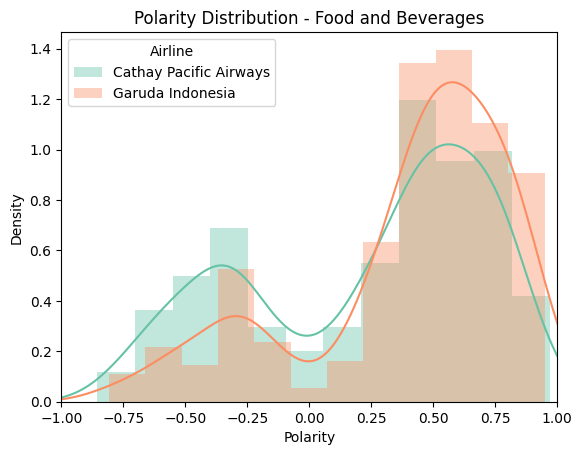

In [85]:
sns.distplot(testplot1['Polarity'], bins=12, label = 'Cathay Pacific Airways').set(title='Polarity Distribution - Food and Beverages')
sns.distplot(testplot2['Polarity'], bins=12, label = 'Garuda Indonesia').set(title='Polarity Distribution - Food and Beverages')
plt.xlim(-1, 1)
plt.legend(title='Airline')

In [86]:
#sentences.to_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Sentences and Topics.xlsx")

In [87]:
len(sentences[sentences['Polarity'] != 0.0]), len(sentences)

(135957, 196902)

# 6 Polarity Update

Testing out additional NLP models to improve polarity ratings

In [88]:
pol_sents = test_sents['Sentence'].copy()
pol_sents

0     before we even left ba changed our seats to a ...
1     i paid $1,500 for the joy of flying with air e...
2                                 ife was very limited.
3     online check-in process is straight-forward, w...
4        i've emailed etihad to investigate the matter.
                            ...                        
95     first they forgot our luggage on our way ther...
96        it was tasteful and good for a 50 min flight.
97    etihad sit somewhere between a budget airline ...
98    the new thales entertainment system was intuit...
99    because of these errors on their part, we miss...
Name: Sentence, Length: 100, dtype: object

In [89]:
from flair.models import TextClassifier
from flair.data import Sentence
import torch
from torch.nn.functional import normalize

import torch.nn.functional as F

## Trying BERT

In [90]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [91]:
pol_sents[1]

'i paid $1,500 for the joy of flying with air europa as there is a very limited choice of airlines from which to choose on the caracas to madrid route.'

In [92]:
def sentiment_analysis(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    prob_result = F.softmax(result.logits, dim=-1)
    return prob_result.tolist()[0]

testlist = sentiment_analysis(pol_sents[1])
testlist

[0.21210838854312897,
 0.2293224334716797,
 0.22810864448547363,
 0.19040876626968384,
 0.14005181193351746]

In [93]:
def compound_score(list):
    score = 1*list[0] + 2*list[1] + 3*list[2] + 4*list[3] + 5*list[4]
    return score

compound_score(testlist)

2.816973313689232

In [94]:
pol_scores = []
for i in range(len(pol_sents)):
    prob_list = sentiment_analysis(pol_sents[i])
    score = compound_score(prob_list)
    pol_scores.append(score)
pol_scores[:10]

[2.122955597937107,
 2.816973313689232,
 2.4047302808612585,
 3.4538238551467657,
 2.430215820670128,
 2.3960964530706406,
 2.709491491317749,
 1.8129599429666996,
 2.9022540487349033,
 3.442398801445961]

In [95]:
# scale list
scaled_list = [round(2 * (x - min(pol_scores)) / (max(pol_scores) - min(pol_scores)) - 1, 4) for x in pol_scores]
scaled_list[:10]

[-0.4596,
 -0.0626,
 -0.2984,
 0.3017,
 -0.2838,
 -0.3033,
 -0.1241,
 -0.6369,
 -0.0138,
 0.2951]

In [96]:
pol_update = pd.DataFrame(zip(pol_sents, scaled_list), columns=['Sentence', 'Polarity'])
pol_update.head(n=20)

,Sentence,Polarity
0,before we even left ba changed our seats to a ...,-0.4596
1,"i paid $1,500 for the joy of flying with air e...",-0.0626
2,ife was very limited.,-0.2984
3,"online check-in process is straight-forward, w...",0.3017
4,i've emailed etihad to investigate the matter.,-0.2838
5,the following hours included: me waiting in li...,-0.3033
6,to top things off even though you've spent tho...,-0.1241
7,our plane was delayed due to weather fair enou...,-0.6369
8,english skills of cabin crew need to be improved.,-0.0138
9,the express pass led me to security screening ...,0.2951


# Works Great :)
# Now Apply this to the entire dataset!

In [97]:
sentences.iloc[29531]

Airline                                             KLM Royal Dutch Airlines
Cabin                                                          Economy Class
Sentence                   the klm staff was very unhelpful and unapologe...
Weight                                                                   0.1
Polarity                                                                 0.0
In-Flight Entertainment                                                    0
Food and Beverages                                                         0
Cabin Service                                                              1
Ground Service                                                             0
Seat Comfort                                                               0
Other                                                                      0
Name: 29531, dtype: object

In [98]:
sentences.shape

(196902, 11)

In [99]:
from tqdm import tqdm_notebook as tqdm

In [100]:
#bert_scores = []

In [101]:
# for i in tqdm(range(len(sentences))):
#     prob_list = sentiment_analysis(sentences['Sentence'].iloc[i])
#     score = compound_score(prob_list)
#     bert_scores.append(score)


# bert_scores_df = pd.DataFrame(bert_scores)
# bert_scores_df.to_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\BERT scores\BERT scores.xlsx")

# bert_scores[:20]

In [102]:
#bert_scores[:20]

NameError: name 'bert_scores' is not defined

In [103]:
sentiment_analysis(sentences['Sentence'].iloc[29531])

[0.6138346791267395,
 0.3400612771511078,
 0.04204213246703148,
 0.0028921235352754593,
 0.0011697666486725211]

In [104]:
bert_scores = pd.read_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\BERT scores\BERT scores.xlsx")

In [108]:
bert_scores = bert_scores.drop('Unnamed: 0', axis=1)

In [109]:
bert_scores.columns = ['score']
bert_scores.head()

,score
0,2.681154
1,4.622979
2,2.281883
3,1.888776
4,2.120232


In [110]:
bert_list = bert_scores['score'].tolist()

In [371]:
bert_list[29531]

4.674382937140763

In [111]:
bert_list[29531]

1.437500958214514

In [373]:
bert_scores.iloc[29531]

score    4.674383
Name: 29531, dtype: float64

[-0.4082, -0.7864]

In [112]:
min_lst = min(bert_list)
max_lst = max(bert_list)

# scale list
scaled_bert_list = [round(2 * (x - min_lst) / (max_lst - min_lst) - 1, 4) for x in bert_list]

In [114]:
sentences.insert(loc=5, column='BERT Polarity', value=scaled_bert_list)

In [115]:
sentences.rename(columns={'Polarity':'VADER Polarity'}, inplace = True)

In [116]:
sentences.head()

,Airline,Cabin,Sentence,Weight,VADER Polarity,BERT Polarity,In-Flight Entertainment,Food and Beverages,Cabin Service,Ground Service,Seat Comfort,Other
0,Turkish Airlines,Economy Class,first time i'd flown tk.,0.1,0.0000,-0.1606,0,0,0,0,0,1
1,Turkish Airlines,Economy Class,"i found them very good in the air, cabin crew,...",0.1,0.7420,0.8166,0,1,1,0,0,0
2,Turkish Airlines,Economy Class,"not so great on the ground, ground staff, call...",0.1,-0.5440,-0.3615,0,0,0,1,0,0
3,Turkish Airlines,Economy Class,my flight from lhr was delayed so i missed the...,0.1,-0.5812,-0.5593,0,0,0,0,0,1
4,Turkish Airlines,Economy Class,"most ground staff don't speak english, and i w...",0.1,-0.3400,-0.4428,0,0,0,1,0,0


In [117]:
testplot1 = sentences[(sentences['Food and Beverages'] == 1) & (sentences['VADER Polarity'] != 0.0) & (sentences['Airline'] == 'Cathay Pacific Airways')]
testplot2 = sentences[(sentences['Food and Beverages'] == 1) & (sentences['VADER Polarity'] != 0.0) & (sentences['Airline'] == 'Garuda Indonesia')]

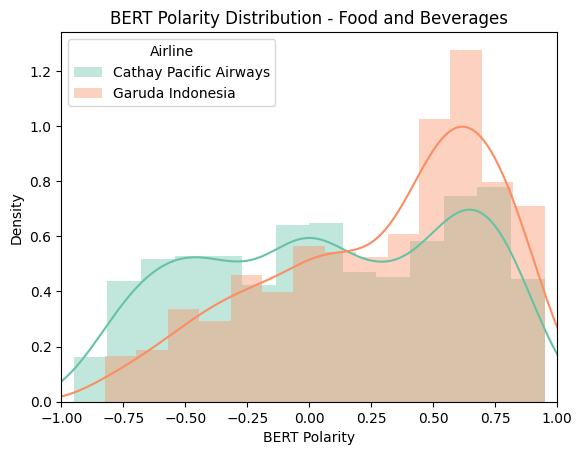

In [118]:
sns.distplot(testplot1['BERT Polarity'], bins=14, label = 'Cathay Pacific Airways').set(title='BERT Polarity Distribution - Food and Beverages')
sns.distplot(testplot2['BERT Polarity'], bins=14, label = 'Garuda Indonesia').set(title='BERT Polarity Distribution - Food and Beverages')
plt.xlim(-1, 1)
plt.legend(title='Airline')

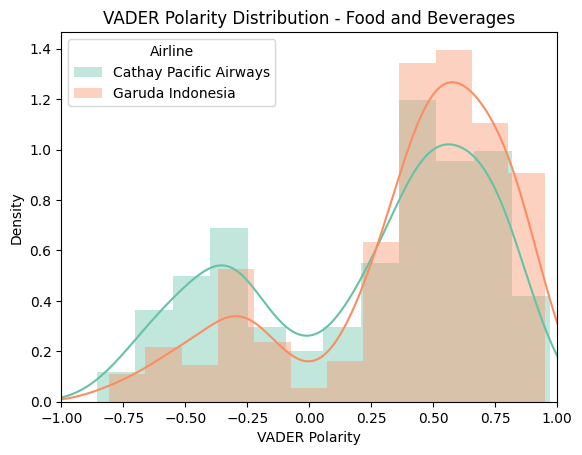

In [119]:
sns.distplot(testplot1['VADER Polarity'], bins=12, label = 'Cathay Pacific Airways').set(title='VADER Polarity Distribution - Food and Beverages')
sns.distplot(testplot2['VADER Polarity'], bins=12, label = 'Garuda Indonesia').set(title='VADER Polarity Distribution - Food and Beverages')
plt.xlim(-1, 1)
plt.legend(title='Airline')

In [120]:
acc_test = sentences.sample(100)
acc_test = acc_test[['Sentence', 'BERT Polarity', 'In-Flight Entertainment', 'Food and Beverages', 'Cabin Service', 'Ground Service', 'Seat Comfort', 'Other']].copy()
acc_test.head()

,Sentence,BERT Polarity,In-Flight Entertainment,Food and Beverages,Cabin Service,Ground Service,Seat Comfort,Other
120860,i said i'd have both since dinner wasn't served.,-0.3354,0,1,0,0,0,0
195136,the only contact on the website is an email.,-0.0678,0,0,0,1,0,0
157858,"when i booked possibly i was naã¯ve, the pric...",-0.0519,0,1,0,0,0,0
138918,the worst customer service experience ever!,-0.9741,0,0,0,1,0,0
11704,pre-departure drinks in cph offered but with s...,-0.0502,0,1,0,0,0,0


In [121]:
acc_test.to_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Acc Test 2.xlsx")

In [122]:
testplot1 = sentences[(sentences['Food and Beverages'] == 1) & (sentences['Airline'] == 'Cathay Pacific Airways')]
testplot2 = sentences[(sentences['Food and Beverages'] == 1) & (sentences['Airline'] == 'Garuda Indonesia')]

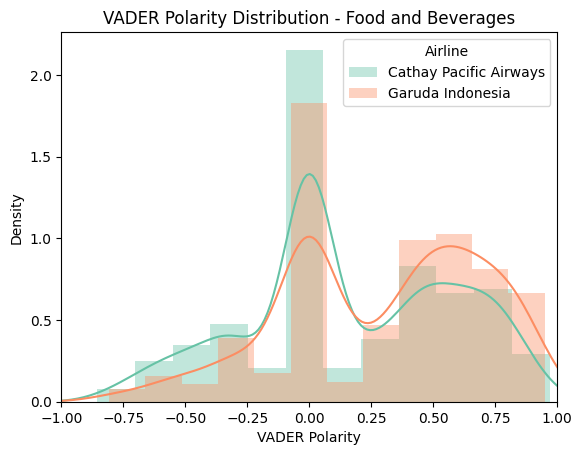

In [123]:
sns.distplot(testplot1['VADER Polarity'], bins=12, label = 'Cathay Pacific Airways').set(title='VADER Polarity Distribution - Food and Beverages')
sns.distplot(testplot2['VADER Polarity'], bins=12, label = 'Garuda Indonesia').set(title='VADER Polarity Distribution - Food and Beverages')
plt.xlim(-1, 1)
plt.legend(title='Airline')

## New Classification Accuracy Test: 88,33% 

In [345]:
#sentences = sentences.drop('Polarity', axis=1)

In [158]:
#sentences.to_excel(r"C:\Users\mark7\OneDrive\Documenten\Bachelor Project\Sentences and Topics.xlsx")

In [174]:
sentences.sample(5)

,Airline,Cabin,Sentence,Weight,VADER Polarity,BERT Polarity,In-Flight Entertainment,Food and Beverages,Cabin Service,Ground Service,Seat Comfort,Other
85957,British Airways,Business Class,must be terrible working for ba now knowing th...,0.100000,-0.7644,-0.9077,0,0,0,0,0,1
193036,Gulf Air,Economy Class,cabin service on all flights was nothing speci...,0.083333,-0.1603,0.0713,0,1,1,0,0,0
129311,Etihad Airways,Business Class,"however, the second leg of our flight 12.5 hrs...",0.045455,-0.4404,-0.4289,0,0,0,0,0,1
13296,Qatar Airways,Business Class,food and beverages were of excellent quality t...,0.111111,0.5719,0.8326,0,1,0,1,0,0
87114,British Airways,Economy Class,"absolutely atrocious customer service, lousy p...",0.047619,-0.5423,-0.9923,0,0,0,1,0,0


In [160]:
sentences['Sentence'].iloc[24972]

' lufthansa claims to have gate arrival/transfer assistance for first class passengers.'